# File: exercise_0.ipynb
Description: A Python/PyRoot/RooFit tutorial! Implementation of Glen Cowan's exercise: Fit an exponential to data
 - Created: 4 June 2013 Harrison B. Prosper, INFN SOS 2013, Vietri sul Mare, Italy
 - Adapted for CMSDAS 2016, LPC Fermilab, Harrison B. Prosper
 - Adapted for CMSDAS 2019, LPC Fermilab, Javier Duarte

In [1]:
# Load the operating system and system modules into memory
import os,sys

# Load the sleep function from the time module
from time import sleep
import math

# Load everything that is in PyROOT. 
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [2]:
# We shall use a package called RooFit, compiled with ROOT,
# in order to fit an exponential function to data.
#
# Suppress all messages except those that matter
msgservice = rt.RooMsgService.instance()
# If a crash occurs, or things look strange,
# comment out next line to find out more information
# about the problem.
msgservice.setGlobalKillBelow(rt.RooFit.FATAL)

# The most convenient way to use RooFit/RooStats is to 
# make a workspace so that we can use its factory method
wspace = rt.RooWorkspace('CMSDAS16')

In [3]:
#-----------------------------------------------------
# Create a double-exponential model
#-----------------------------------------------------
# The observable is x and lies in the range [0, 20]
xmin = 0.0 # note this is a float
xmax = 20.0 # and so is this

# Use the factory method of the RooWorkspace object, just
# created, to create an object called x that represents the
# observable.
# syntax:
#        <name>[value, min-value, max-value]
#
# We are using Python's ability to write numbers into strings,
# which is modeled on C
wspace.factory('x[0,%f,%f]' % (xmin, xmax))

#---------------------------
# Set the NUMBER OF BINS,
# either for display purposes
# or for the binned fit.
#---------------------------
M = 15 
wspace.var('x').setBins(M)

# The parameters of the model are a, b, c
wspace.factory('a[0.4, 0.0,   1.0]')
wspace.factory('b[3.0, 0.01, 20.0]')
wspace.factory('c[9.0, 0.01, 20.0]')
parameters = ['a', 'b', 'c']

# NUMBER OF PARAMETERS
P = len(parameters)

In [4]:
# The model to be fitted, called "model", is defined
# by a probability density function (pdf) of the form
#
#   p(x|a, b, c) = a*exp(-x/b)/b + (1-a)*exp(-x/c)/c
#
# The syntax for creating a pdf, here a user-defined pdf using
# the class RooGenericPdf, is:
#
# GenericPdf::<user-defined-name>("<function>", {...})
#
# where we always drop the "Roo" prefix. Note use of braces {..}
# in the above to specify a list of variables
# (modeled in RooFit by the RooArgList class).
#
# POWERFUL TIP: a function can be a call to a C++
# function (with double and int arguments), compiled
# using
#
#  gROOT.ProcessLine(open('<function>.cc').read())
#
# and made known to Python using
#
#  from ROOT import <function>
#
# The Python file open object reads the specified file as one
# continuous string, which is then passed to ProcessLine. The
# latter compiles it using a just-in-time compiler (in Root 6).
# Since Root 6 uses a real compiler (rather than an interpreter),
# the syntax of your C++ code must conform to standard C++.
#
# If you need to make the compiler and linker happy by including
# headers and libraries other the the default set provided by ROOT,
# first do
#
#   gSystem.AddInlcudePath('-I<path1> ...')
#   gSystem.AddLinkedLibs('-L<libdir> -l<library> ...')
#
# before calling gROOT.ProcessLine

# Note use of "\" continuation markers below

# Here is a direct way to create the model:
#
# wspace.factory('GenericPdf::model'\
#                '("a*exp(-x/b)/b + (1-a)*exp(-x/c)/c",'\
#                '{x,a,c,c})')

# and here is a way to do the same thing via a C++ function:

rt.gROOT.ProcessLine(open('models.cc').read())
from ROOT import dbexp
wspace.factory('GenericPdf::model("dbexp(x,a,b,c)", {x,a,b,c})')

   
# So far, the "model" is known only to the RooFit workspace.
# Make the model known to Python also
model = wspace.pdf('model')

In [5]:
#----------------------------------------------------
# now we generate some data from the model,
# then try to fit the latter to these data
#----------------------------------------------------
# define the set obs = (x)
wspace.defineSet('obs', 'x')

# make the set obs known to Python
obs  = wspace.set('obs')

# now, generate data
T = 400 # number of data to generate
data = model.generate(obs, T)

In [6]:
#----------------------------------------------------
# Part 1: do an unbinned fit to data
#----------------------------------------------------
print "="*80
print "\t\t unbinned fit to data"
print "="*80

# Obvious, right?!! :)
swatch = rt.TStopwatch()
swatch.Start()

# If more control is needed, you can call RooMinuit
# directly, which is an interface to Minuit.
# Here, we are happy to use the simpler interface "fitTo".
# Remember to save the results of the fit
results = model.fitTo(data, rt.RooFit.Save())
print "real time: %10.3f s" % swatch.RealTime()

# Let's see what we get
print "="*80
results.Print()

# Print correlation matrix as a matrix.
# Note use of "," at the end of the print statement
# to suppress a newline
print "\tcorrelation matrix"
print "%10s" % "",
for v in parameters:
    print "%10s\n" % v,
for v1 in parameters:
    print "%-10s" % v1, # first print label and suppress a newline
    for v2 in parameters:
        cor = results.correlation(v1, v2)
        print '%10.3f\n' % cor

		 unbinned fit to data
real time:      0.142 s
	correlation matrix
                    a
         b
         c
a               1.000

     0.926

     0.924

b               0.926

     1.000

     0.828

c               0.924

     0.828

     1.000

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            4.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     2 b            3.00000e+00  1.49500e+00    1.00000e-02  2.00000e+01
     3 c            9.00000e+00  1.99900e+00    1.00000e-02  2.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT

Info in <TCanvas::Print>: png file ./fig_unbinnedFit.png has been created


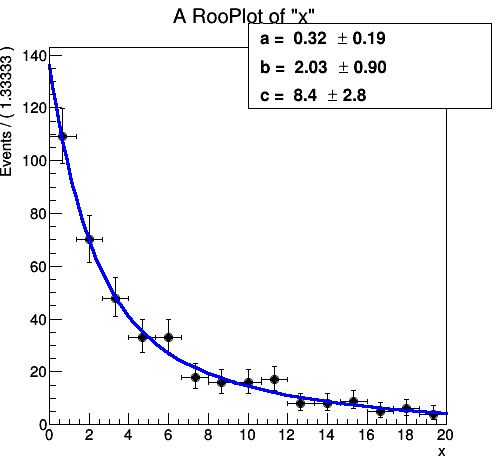

In [7]:
#---------------------------
# plot
#---------------------------
# This is how RooFit makes plots. Alas, it is not as
# intuitive as it could have been!
#
# We wish to plot the distribution of the data and
# superimpose the fitted model as a function of the
# observable x.
#
# In RooFit, one does proceeds as follows:
# 1. create a frame pertaining to x (which we call xframe)
# 2. set the frame's attributes, of which there are many
# 3. tell the data to place a plot of themselves on xframe
# 4. tell the model to place a plot of itself on xframe
# 5. tell the model to place its parameters on xframe
# 6. tell the xframe to draw itself on the active canvas

xframe = wspace.var('x').frame()
xframe.SetMinimum(0) # set minimum y-axis value 
xframe.SetMaximum(100)   # set maximum y-axis value
data.plotOn(xframe)
model.plotOn(xframe)
model.paramOn(xframe)

# If you have trouble making the plot look exactly as you
# wish it to look, try drawing an empty Root histogram
# first in order to define the plotting area, then Draw
# xframe using the "same" option.
#
# Place upper lefthand corner of canvas at pixel position (10, 10)
# of your screen. (0,0) is the upper lefthand corner.

c1 = rt.TCanvas('fig_unbinnedFit', 'fit', 10, 10, 500, 500)
xframe.Draw()
c1.Draw()
c1.SaveAs('.png')

DataStore hdata (binned data)
  Contains 15 entries
  Observables: 
    1)  x = 5.44215  L(0 - 20) B(15)  "x"
Binned Dataset hdata (binned data)
  Contains 15 bins with a total weight of 400
  Observables:     1)  x = 5.44215  L(0 - 20) B(15)  "x"
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            3.22060e-01  1.85863e-01    0.00000e+00  1.00000e+00
     2 b            2.02937e+00  9.03784e-01    1.00000e-02  2.00000e+01
     3 c            8.40860e+00  2.80058e+00    1.00000e-02  2.00000e+01
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           1
 **********
 **********
 **   14 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   15 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WIT

Info in <TCanvas::Print>: png file ./fig_binnedFit.png has been created


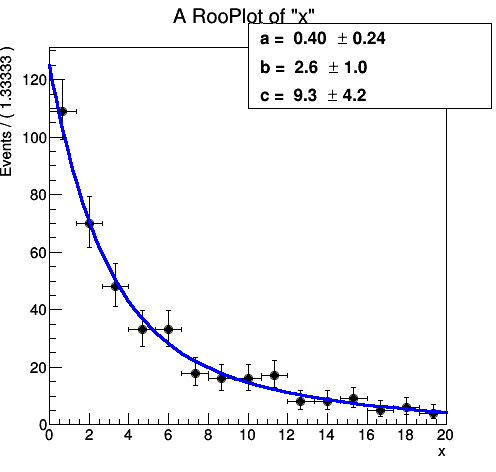

In [8]:
#---------------------------------------------------
# Part 2: do a binned fit
#---------------------------------------------------
# Bin the data using RooDataHist

# note use of set obs, created above, to tell
# RooDataHist the variable(s) with respect to
# which the data are to be binned. the number of
# bins is obtained from the bin count attribute of "x"
# (see above)
hdata = rt.RooDataHist('hdata', 'binned data', obs)
hdata.add(data)  # add the data to the RooDataHist and bin them
print "="*40
hdata.Print('verbose')
print "="*40

# Do a multinomial fit to the binned data by
# turning off extended likelihood mode. If you
# want a multi-Poisson fit, change False to True.
# (If interested, ask what all this means!)
results2 = model.fitTo(hdata,
                       rt.RooFit.Save(),
                       rt.RooFit.Extended(False))
results2.Print()

# Plot results of fit on a different frame
c2 = rt.TCanvas('fig_binnedFit', 'fit',
              515, 10, 500, 500)

xframe2 = wspace.var('x').frame()
xframe2.SetMaximum(0)
xframe2.SetMaximum(100)
hdata.plotOn(xframe2)
model.plotOn(xframe2)
model.paramOn(xframe2)
xframe2.Draw()
c2.Draw()
c2.SaveAs('.png')
print "="*80

In [9]:
#---------------------------------------------------
# Part 3: Let's do a bit of statistics. We shall
# compute two goodness-of-fit (gof) measures X and Y
#---------------------------------------------------
# Since we have binned data, we need to create an
# integral to integrate the model over a each x-bin
# so that we can compare the expected count in a given
# bin with the observed count in that bin.
#
# 1. Define the set of variables over which to
# normalize the integral
normSet = rt.RooFit.NormSet(obs) 

# 2. Define a range variable, call it x-bin, to
# represent the bin boundaries.
wspace.var('x').setRange('x-bin', xmin, xmax)

# 3. Create integral
integral = model.createIntegral(obs,
                                normSet,
                                rt.RooFit.Range('x-bin'))

# 4. We now compute two gof measures (with the
# restriction that the observed count N_i > 5)
# i.X = sum_i=1^M (N_i - n_i)^2 / n_i,
#
#where n_i = int_bin_i f(x; theta_hat) dx
#
# ii.   Y = -2 ln p(N | n) / p(N | N),
#
# where p(N | n) is a multinomial likelihood; N denotes the counts
# N_1,...N_M and n denotes the mean counts. Note that n_i is
# evaluated at theta = theta_hat, that is, at the maximum
# likelihood (ML) estimates of the parameters of the model,
# here a, b, and c.
#
# Let H_0 be the hypothesis that theta_0 are the true values
# of the parameters theta. In practice, we estimate theta_0 using
# ML and approximate theta_0 by theta_hat.
#
# According to Wilks' theorem (1938), the quantity X has
# (asymptotically) a chi-squared distribution of N - 1 - P
# degrees of freedom, where
#   N - number of bins
#   P - number of fitted parameters
#
# Interestingly, Y follows the same distribution asymptotically.
#
# Procedure:
#   loop over bins
#  compute integral over bin to obtain n_i
#  accumulate X and Y with restriction that N_i > 5
#
#   compute p-value = Pr[X > X_obs]
#   p-value = Pr[Y > Y_obs]
#

# Find bin width. Use float function to make sure we have
# a float in the numerator to avoid truncation.
dx = float(xmax-xmin)/M
X = 0.0
Y = 0.0
total = 0.0 # to check the total integral (should be = T)
print
print "%5s\t%10s %5s %10s" % ('', 'binlow', "count", "mean")

# range(M) = [0, 1,...M-1]
K = 0 # count number of bins with N_i > 5
for ii in range(M):
    # Get count in bin ii
    # Yes, this is not as tidy as it could have been!
    ibin = hdata.get(ii)   # get object that models iith bin
    Ni   = hdata.weight()  # get bin content (count)

    # Set the bin boundaries in our previously created
    # range object
    x = xmin + ii * dx
    wspace.var('x').setRange('x-bin', x, x+dx)

    # Compute the integral, with respect to x, over current
    # bin and scale result by the total observed count. This
    # gives us the mean count in current bin
    ni = T * integral.getVal()
    print "%5d\t%10.3f %5d %10.1f" % (ii+1, x, Ni, ni)
    
    total += ni
    if Ni < 5: continue

    # Accumulate X and Y
    K += 1
    X += (Ni - ni)**2 / ni
    Y += Ni * math.log(ni/Ni) 

# Complete calculation of Y
Y *= -2

# 5. Assuming we are in asymptotia, compute
# p-value = Int_Y^infinity p(chi^2, ndf) dchi^2
# where p(chi^2, ndf) is the chi2 density of ndf
# degrees of freedom

ndf = K-P-1  # number of degrees of freedom
    
if ndf > 0:
    pvalueX = rt.TMath.Prob(X, ndf)
    pvalueY = rt.TMath.Prob(Y, ndf)
else:
    pvalueX = 1.0
    pvalueY = 1.0
print "="*80
print "Int p(x|xi) dx =%6.1f\n" % total

print "ChiSq/ndf = %6.1f/%d (using X)" % (X, ndf)
print "p-value   = %9.4f\n" % pvalueX
   
print "ChiSq/ndf = %6.1f/%d (using Y)" % (Y, ndf)
print "p-value   = %9.4f" % pvalueY


     	    binlow count       mean
    1	     0.000   109      103.4
    2	     1.333    70       71.1
    3	     2.667    48       50.6
    4	     4.000    33       37.2
    5	     5.333    33       28.3
    6	     6.667    18       22.2
    7	     8.000    16       17.8
    8	     9.333    16       14.6
    9	    10.667    17       12.1
   10	    12.000     8       10.2
   11	    13.333     8        8.7
   12	    14.667     9        7.4
   13	    16.000     5        6.3
   14	    17.333     6        5.4
   15	    18.667     4        4.7
Int p(x|xi) dx = 400.0

ChiSq/ndf =    6.0/10 (using X)
p-value   =    0.8153

ChiSq/ndf =    7.2/10 (using Y)
p-value   =    0.7033
